In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df = pd.read_csv('./datasets/DJI_2yrs.csv', header=0, index_col=0)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/8/2021,34645.84,34665.38,34452.94,34599.82,"296,085,650"
6/9/2021,34626.16,34654.67,34439.37,34447.14,"246,543,250"
6/10/2021,34502.51,34737.79,34447.25,34466.24,"310,878,295"
6/11/2021,34499.81,34618.09,34328.65,34479.60,"262,624,671"
6/14/2021,34472.52,34472.52,34211.54,34393.75,"302,550,505"


<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 6/8/2021 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    505 non-null    float64
 1   High    505 non-null    float64
 2   Low     505 non-null    float64
 3   Close   505 non-null    float64
 4   Volume  505 non-null    object 
dtypes: float64(4), object(1)
memory usage: 23.7+ KB


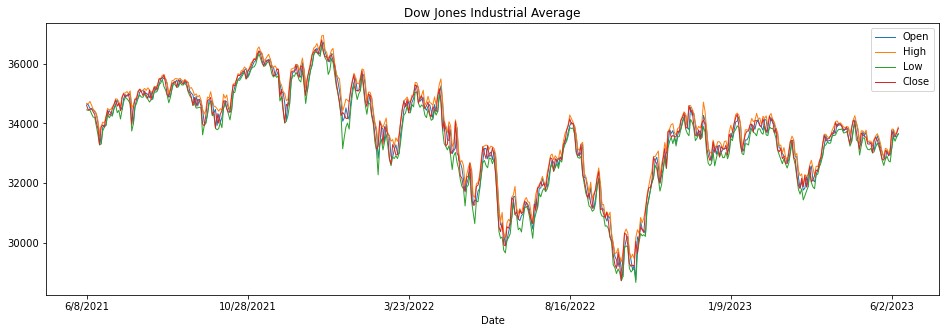

In [4]:
df.info()
df.plot(figsize=(16,5),lw=1, title="Dow Jones Industrial Average")
plt.show()

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 505 entries, 6/8/2021 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
505 non-null    float64
dtypes: float64(1)
memory usage: 7.9+ KB


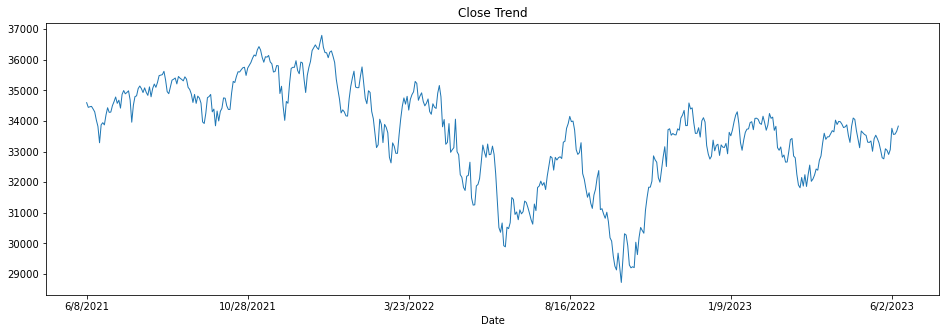

In [5]:
df_close = df["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Split data for train and test

In [6]:
# Split the data for train and test
df_train = df_close[:485].copy()
df_test = df_close[485:].copy()

In [7]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

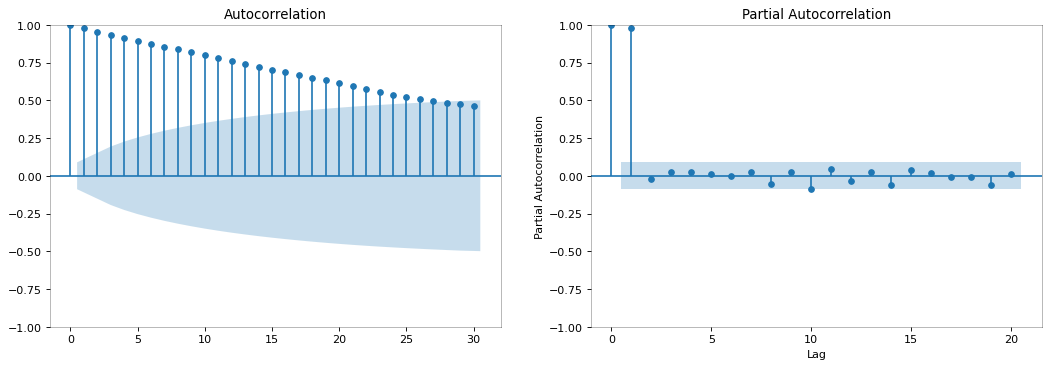

In [8]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [9]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [10]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -2.383214
p-value: 0.146530
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [13]:
from statsmodels.tsa.stattools import kpss

In [11]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [12]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            1.616852
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -5.739999999997963


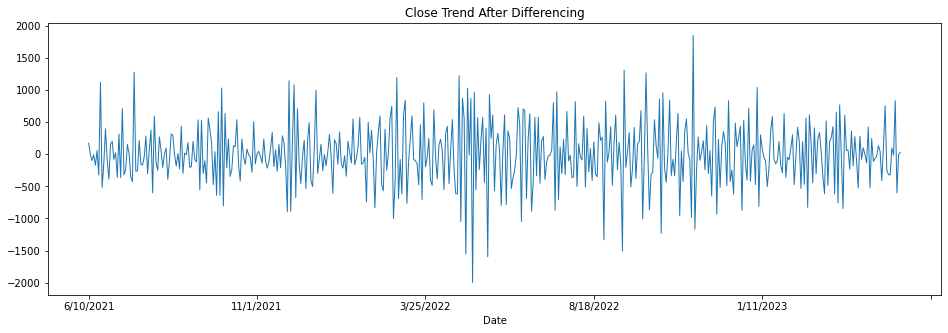

In [14]:
# Perform differencing
df_train_diff = df_train.diff().diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

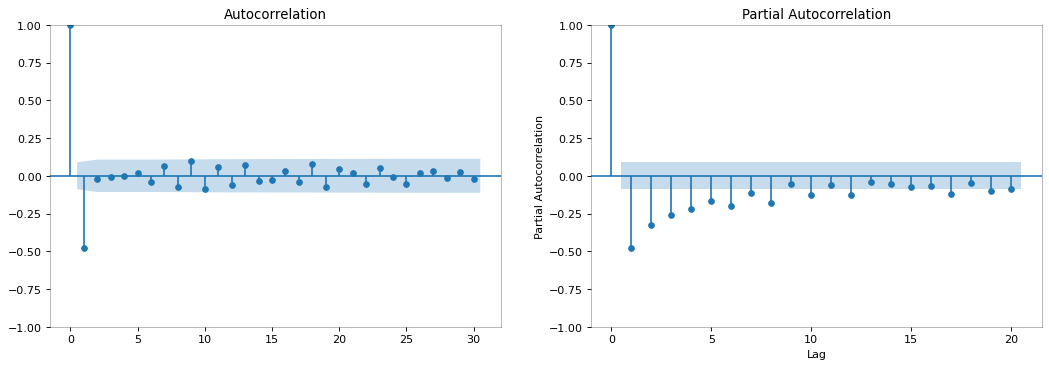

In [15]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [16]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [17]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=2,D=2,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=7859.919, Time=0.28 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=7513.840, Time=2.37 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=7722.059, Time=0.40 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=7379.291, Time=5.02 sec
 ARIMA(1,2,0)(2,2,1)[12]             : AIC=inf, Time=7.17 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=inf, Time=4.10 sec
 ARIMA(0,2,0)(2,2,0)[12]             : AIC=7490.569, Time=1.37 sec
 ARIMA(2,2,0)(2,2,0)[12]             : AIC=7338.996, Time=5.66 sec
 ARIMA(2,2,0)(1,2,0)[12]             : AIC=7480.977, Time=2.77 sec
 ARIMA(2,2,0)(2,2,1)[12]             : AIC=inf, Time=8.16 sec
 ARIMA(2,2,0)(1,2,1)[12]             : AIC=inf, Time=3.94 sec
 ARIMA(2,2,1)(2,2,0)[12]             : AIC=inf, Time=9.28 sec
 ARIMA(1,2,1)(2,2,0)[12]             : AIC=inf, Time=7.32 sec
 ARIMA(2,2,0)(2,2,0)[12] intercept   : AIC=7340.774, T

## Fit the ARIMA Model

In [18]:
model = ARIMA(df_train, order=(2,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  485
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -3608.915
Date:                Fri, 16 Jun 2023   AIC                           7223.831
Time:                        12:25:08   BIC                           7236.371
Sample:                             0   HQIC                          7228.759
                                - 485                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5086      0.019    -26.754      0.000      -0.546      -0.471
ar.L2         -0.2483      0.022    -11.128      0.000      -0.292      -0.205
sigma2      1.678e+05   8901.660     18.847      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Make time series prediction

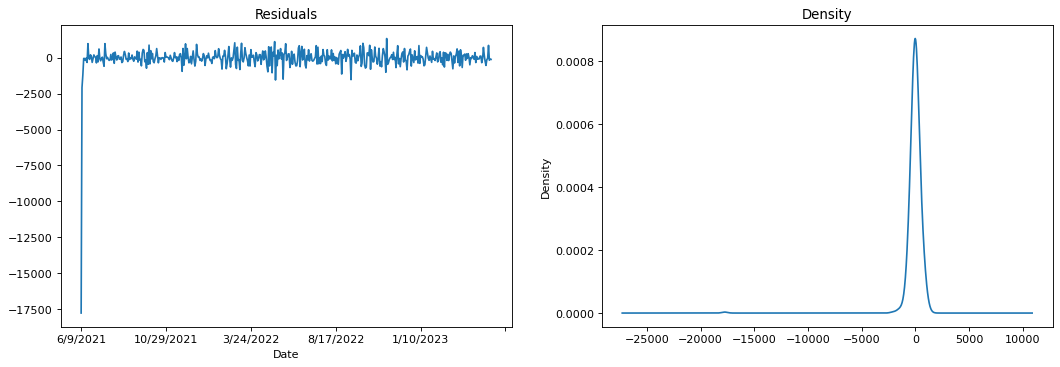

In [19]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

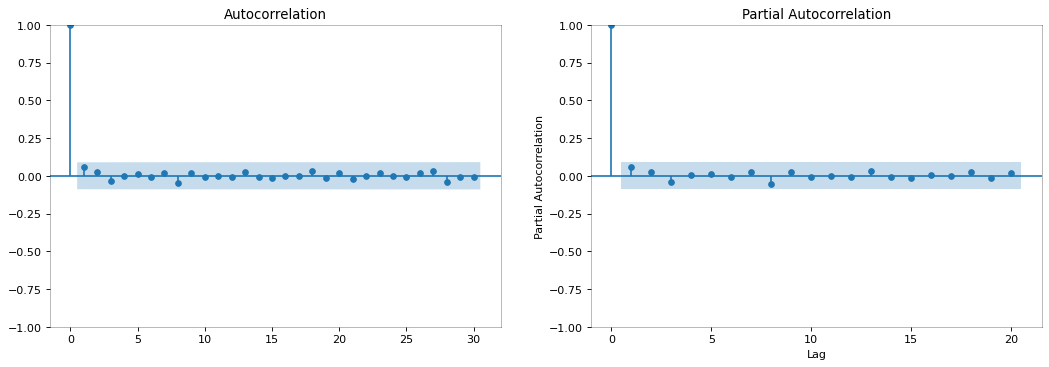

In [20]:
plot_correlation(residuals)

In [21]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
5/11/2023,33487.719086,33309.51
5/12/2023,33444.231737,33300.62
5/15/2023,33403.941634,33348.60
5/16/2023,33361.994815,33012.14
5/17/2023,33320.096761,33420.77
5/18/2023,33278.585229,33535.91
5/19/2023,33236.865015,33426.63
5/22/2023,33195.154967,33286.58
5/23/2023,33153.491559,33055.51


<AxesSubplot:xlabel='Date'>

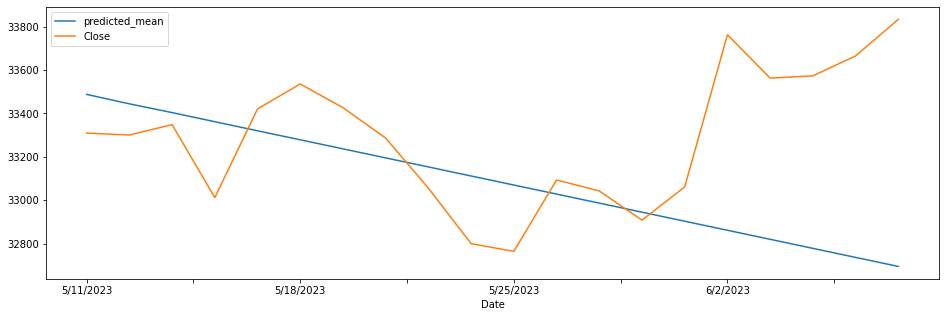

In [23]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [24]:
train = df_close[:485].copy()
test = df_close[485:].copy()

In [25]:
final_model = SARIMAX(train,order=(2,2,0),seasonal_order=(2,2,0,12)) # Best model:  ARIMA(2,2,0)(2,2,0)[12]   
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69814D+00    |proj g|=  1.04117D-01

At iterate    5    f=  7.67440D+00    |proj g|=  4.90739D-04

At iterate   10    f=  7.67429D+00    |proj g|=  7.41843D-03

At iterate   15    f=  7.66138D+00    |proj g|=  1.00316D-01

At iterate   20    f=  7.55717D+00    |proj g|=  1.73180D-02

At iterate   25    f=  7.55567D+00    |proj g|=  9.42775D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   

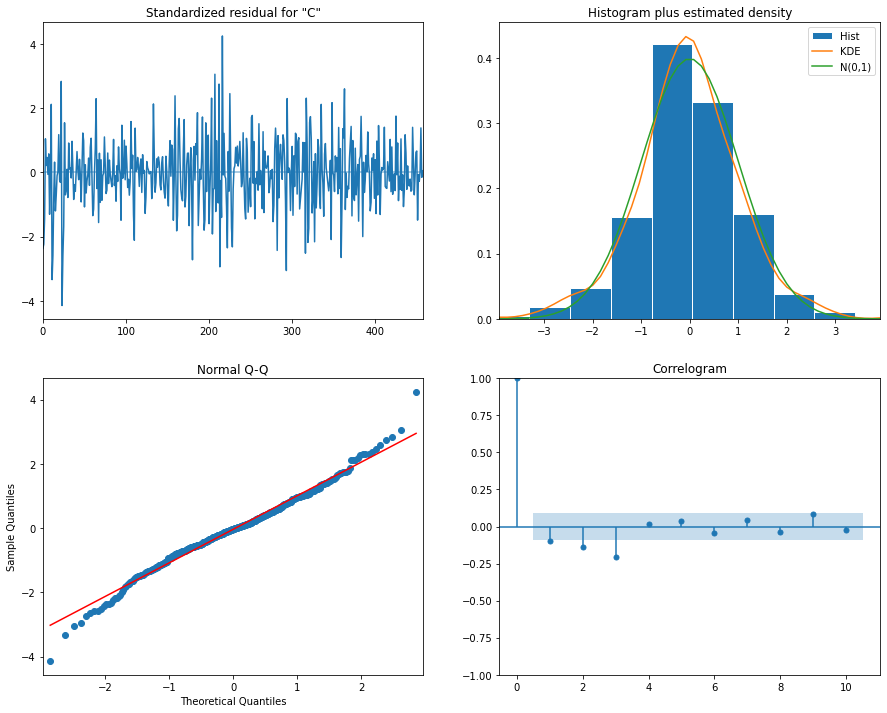

In [26]:
result.plot_diagnostics(figsize=(15, 12));

In [27]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(2,2,0)(2,2,0)[12]   
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,2,0)(2,2,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(2,2,0)(2,2,0,12) Predictions",Close
Date,,
5/11/2023,32940.846837,33309.51
5/12/2023,32680.716100,33300.62
5/15/2023,33545.413195,33348.60
5/16/2023,33842.139133,33012.14
5/17/2023,34156.106292,33420.77
5/18/2023,33844.470423,33535.91
5/19/2023,33610.589281,33426.63
5/22/2023,33123.602168,33286.58
5/23/2023,33821.154010,33055.51


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

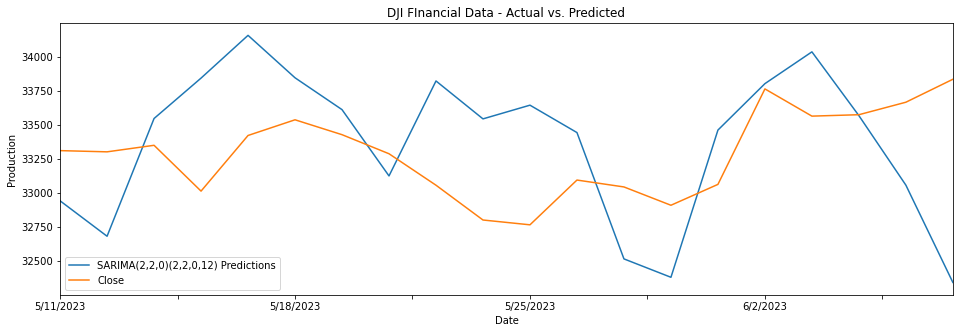

In [29]:
title = 'DJI FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)